In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import itertools
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 16
import numpy as np
import pandas as pd
import requests
import seaborn as sns

import covid19

## data

In [11]:
data_path = 'time_series_covid19_deaths_US.csv'
data_path = covid19.data.download('deaths', repo='usa')
data_path
df = covid19.data.reformat(data_path, kind='usa')
df.index = df.index.normalize()
world_path = covid19.data.download('deaths', repo='world')
world_data = covid19.data.reformat(world_path)


In [17]:
STATES = df.loc[df.index.max()].sort_values('deaths', ascending=False)['location'].tolist()

print(STATES)

data = {state: df[df['location'] == state].sort_index() for state in STATES}
data['US'] = world_data[world_data['country'] == 'US']
data['US minus New York'] = data['US'].copy()
data['US minus New York']['deaths'] -= data['US - New York']['deaths']
for state, d in data.items():
    d['daily_deaths'] = d['deaths'].diff(1)

df.loc[df.index.max()].sort_values('deaths', ascending=False)[['location', 'deaths']].head(15)


['US - New York', 'US - New Jersey', 'US - Michigan', 'US - Louisiana', 'US - Massachusetts', 'US - Illinois', 'US - California', 'US - Pennsylvania', 'US - Washington', 'US - Connecticut', 'US - Florida', 'US - Georgia', 'US - Indiana', 'US - Texas', 'US - Colorado', 'US - Ohio', 'US - Maryland', 'US - Wisconsin', 'US - Virginia', 'US - Missouri', 'US - Arizona', 'US - Tennessee', 'US - Nevada', 'US - Oklahoma', 'US - Mississippi', 'US - Alabama', 'US - Kentucky', 'US - North Carolina', 'US - South Carolina', 'US - Minnesota', 'US - Rhode Island', 'US - Kansas', 'US - Oregon', 'US - District of Columbia', 'US - Puerto Rico', 'US - Iowa', 'US - Delaware', 'US - Arkansas', 'US - Idaho', 'US - Vermont', 'US - New Hampshire', 'US - Maine', 'US - New Mexico', 'US - Nebraska', 'US - Utah', 'US - Alaska', 'US - Hawaii', 'US - North Dakota', 'US - Montana', 'US - South Dakota', 'US - West Virginia', 'US - Guam', 'US - Grand Princess', 'US - Northern Mariana Islands', 'US - Virgin Islands']


,location,deaths
date,,
2020-04-11,US - New York,8627
2020-04-11,US - New Jersey,2183
2020-04-11,US - Michigan,1384
2020-04-11,US - Louisiana,806
2020-04-11,US - Massachusetts,686
2020-04-11,US - Illinois,677
2020-04-11,US - California,605
2020-04-11,US - Pennsylvania,503
2020-04-11,US - Washington,495


In [18]:
DAY = np.timedelta64(24 * 60 * 60, 's')
PALETTE_ONE = list(sns.color_palette())


EXTENT = ('2020-03-01', '2020-04-15')
XLIM = tuple(map(np.datetime64, EXTENT))

In [19]:
i2d_delay = 17
i2d_ratio = .01

for state, df_state in data.items():
    df_state['estimated_infections'] = df_state['deaths'].shift(-i2d_delay) / i2d_ratio


In [33]:
STATES_FIT_PARAMS = {
    'US': {
        'deaths': ['2020-03-05', '2020-03-15', '2020-03-28', '2020-04-05'],
    },
    'US - New York': {
        'deaths': ['2020-03-22', '2020-03-31', '2020-04-05'],
    },
    'US minus New York': {
        'deaths': ['2020-03-05', '2020-04-05'],
    },
    'US - New Jersey': {
        'deaths': [None, '2020-04-05', '2020-04-05'],
    },
    'US - Michigan': {
        'deaths': ['2020-03-25', '2020-04-02', None],
    },
    'US - Louisiana': {
        'deaths': [None, '2020-03-27', None],
    },
    'US - California': {
        'deaths': [None, '2020-03-26', None],
    },
    'US - Washington': {
        'deaths': [None, '2020-03-26', None],
    },
    'US - Massachusetts': {
        'deaths': [None, None],
    },
    'US - Georgia': {
        'deaths': [None, None],
    },
    'US - Illinois': {
        'deaths': [None, None],
    },
    'US - Florida': {
        'deaths': [None, None],
    },
}

In [34]:
region_fits = {}
for region, params in list(STATES_FIT_PARAMS.items()):
    region_fits[region] = {}
    for kind, breaks in params.items():
        region_fits[region][kind] = covid19.fit.fit_exponential_segments(data[region][kind], breaks)
        if 'daily_' + kind in data[region]:
            kinf = 'daily_' + kind 
            region_fits[region][kind] = covid19.fit.fit_exponential_segments(data[region][kind], breaks)


skipping start=2020-04-05T00:00:00 stop=2020-04-04T00:00:00
skipping start=2020-04-05T00:00:00 stop=2020-04-04T00:00:00


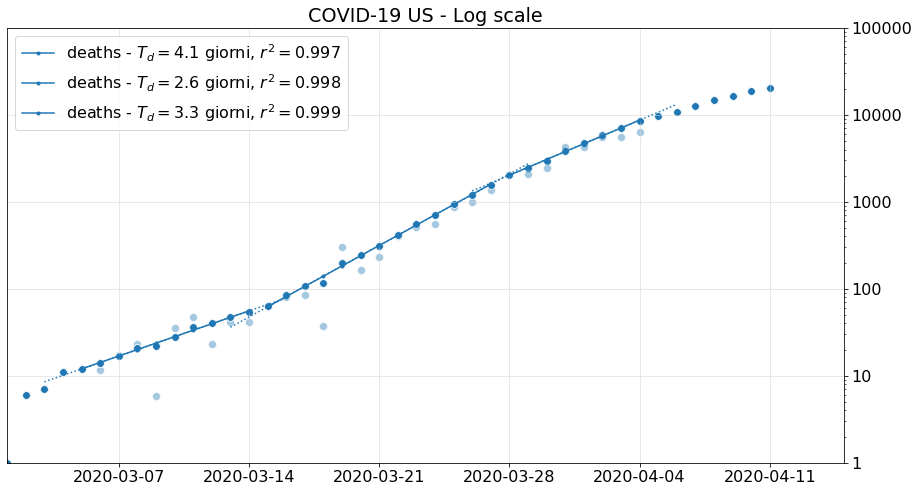

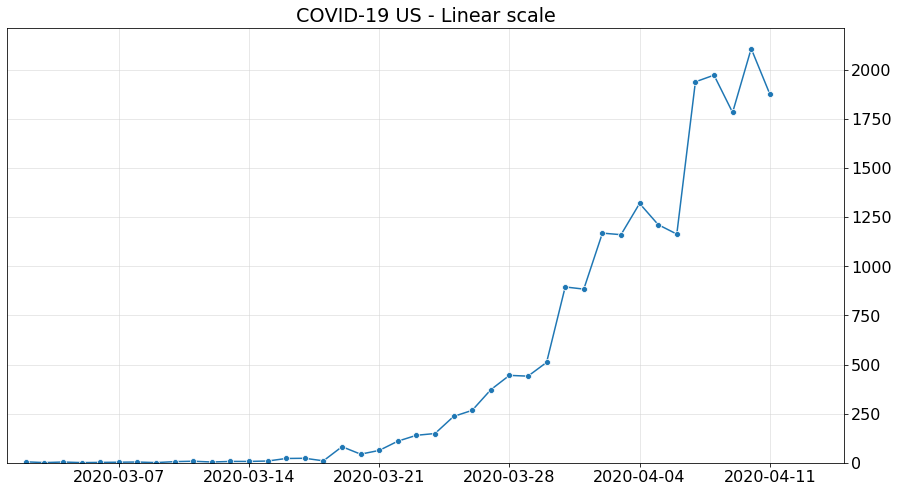

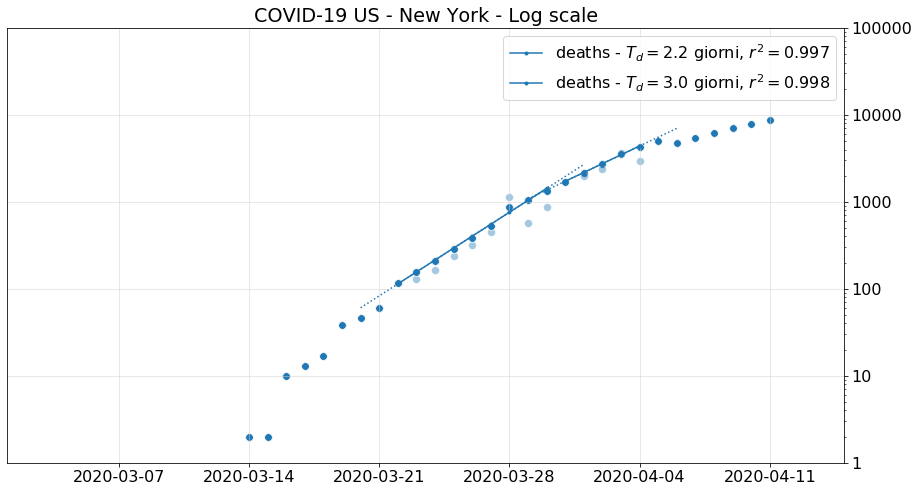

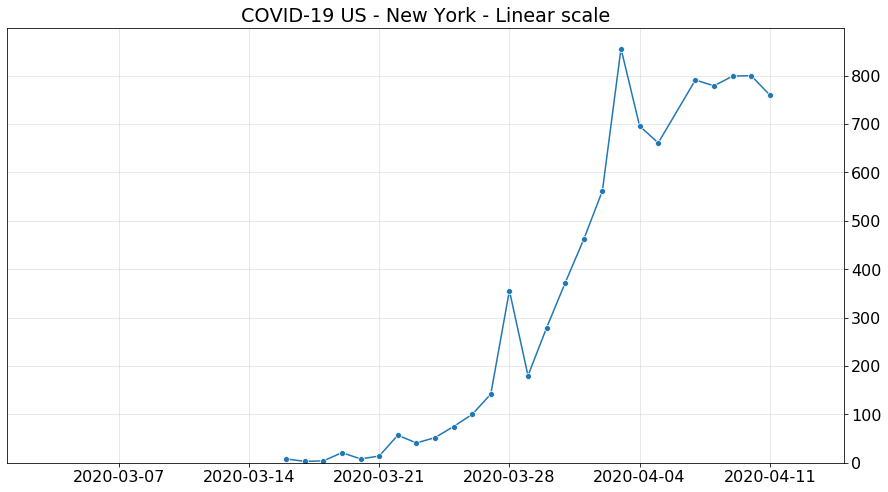

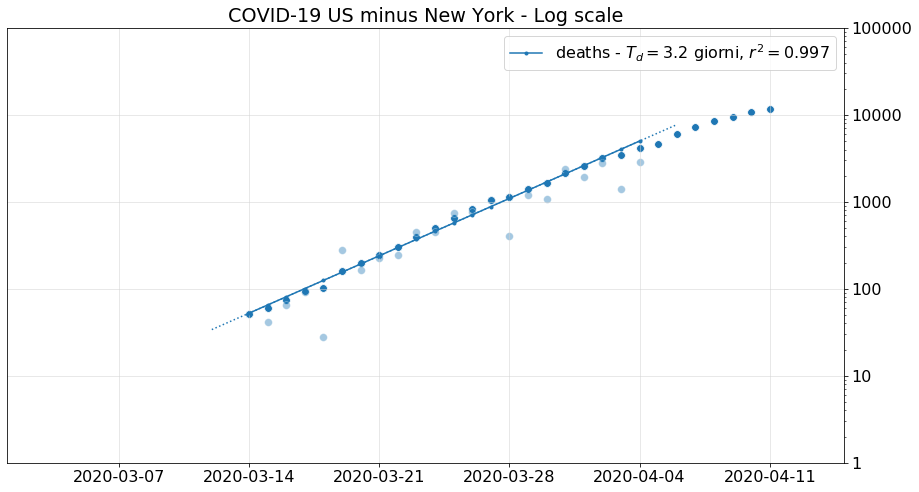

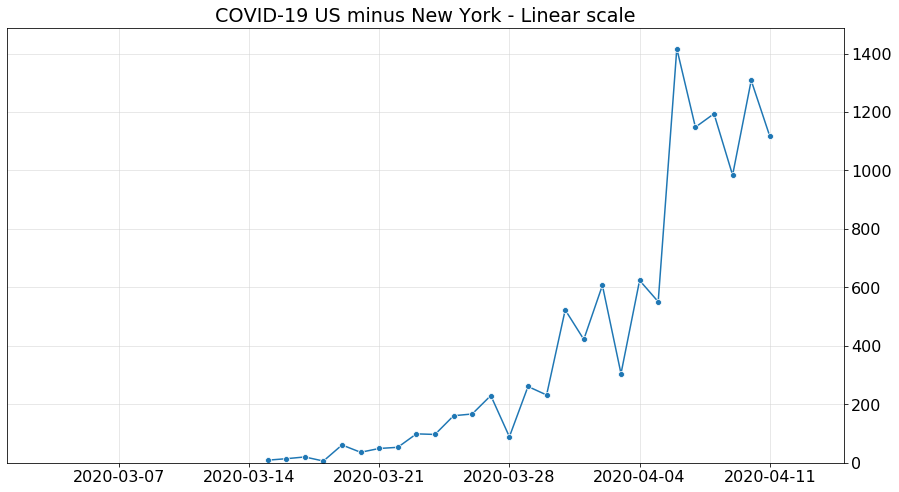

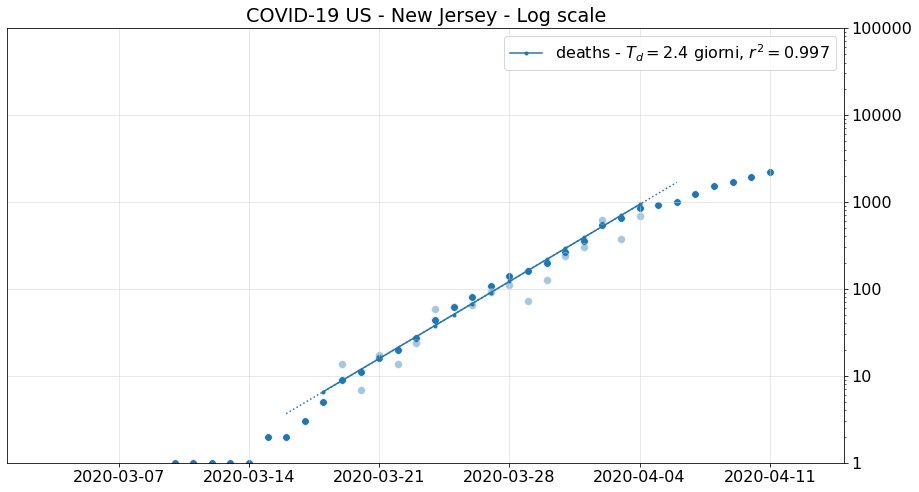

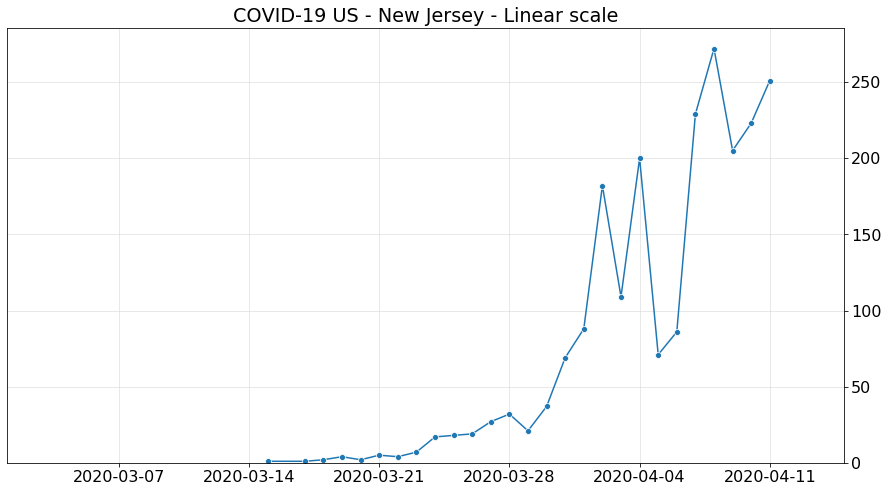

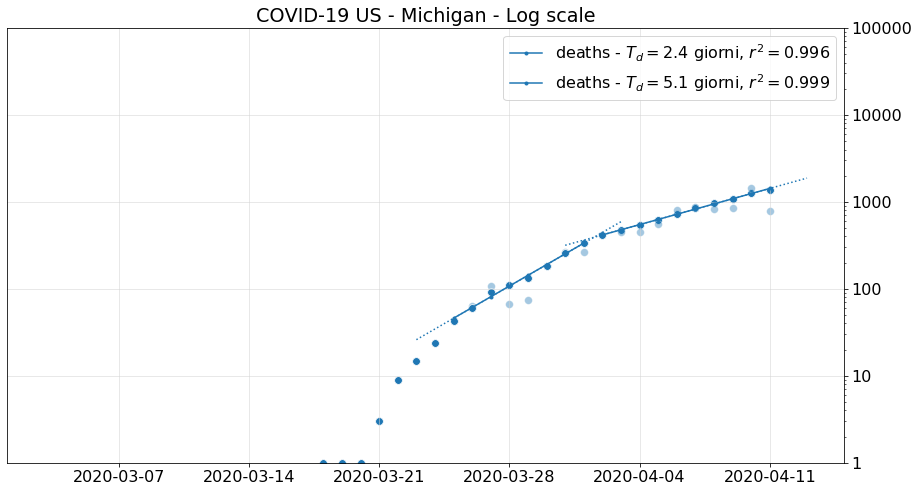

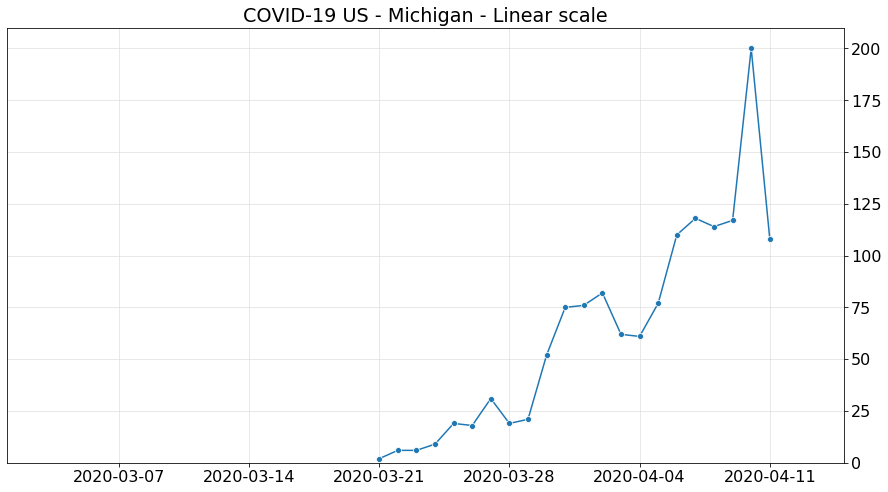

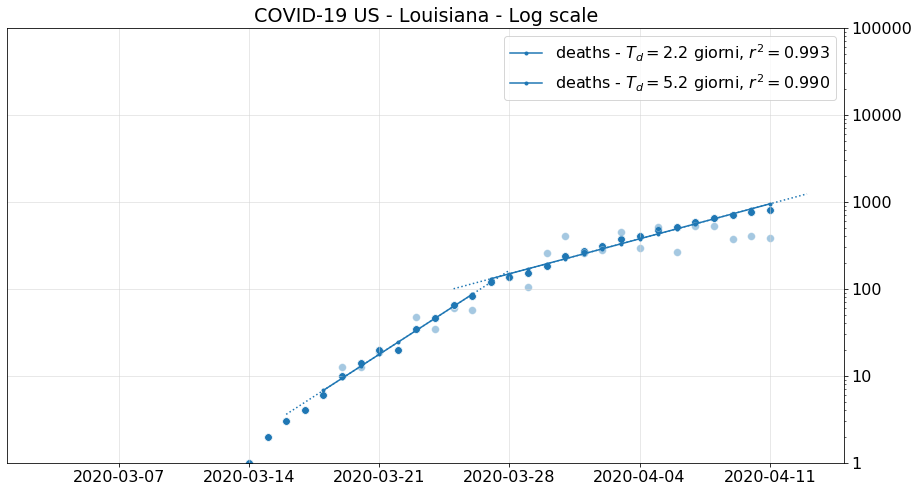

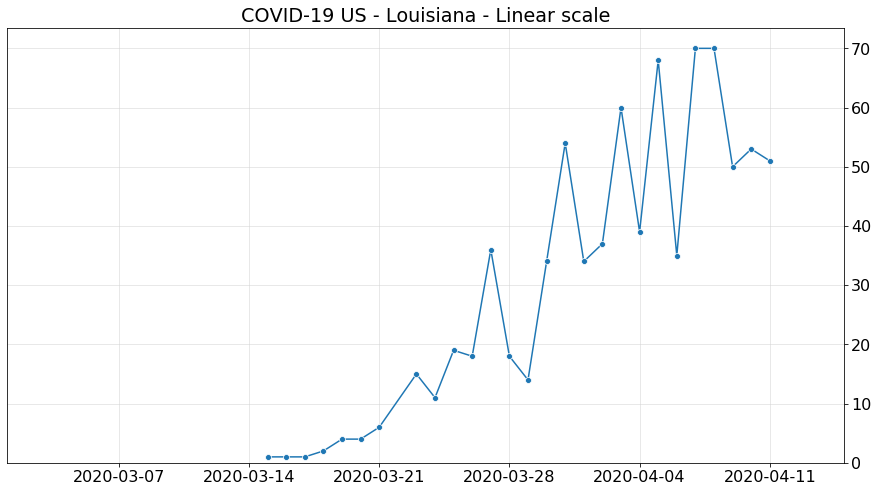

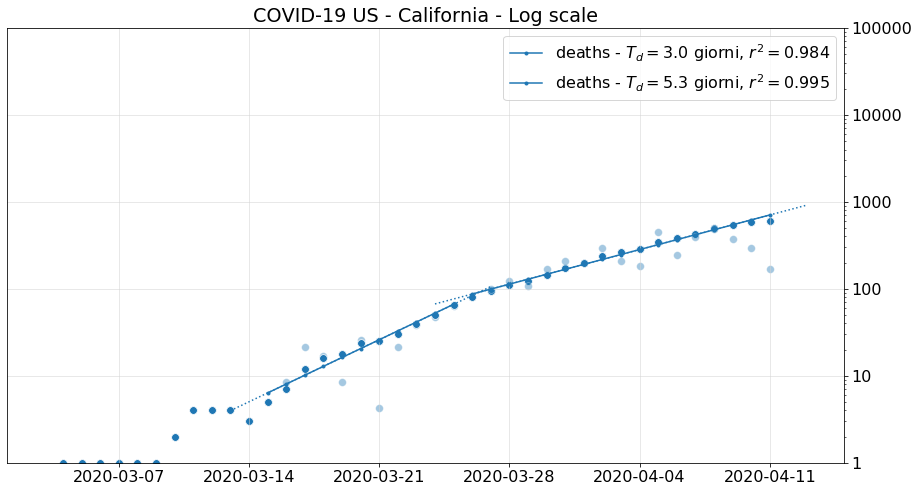

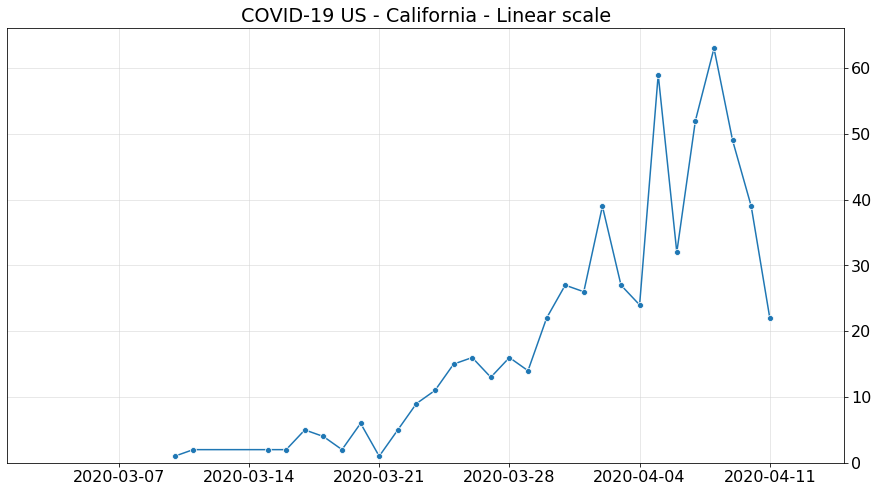

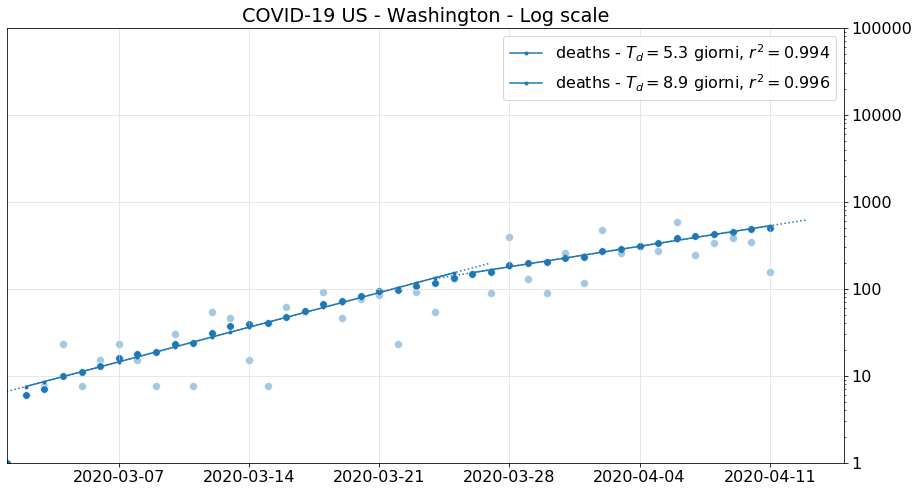

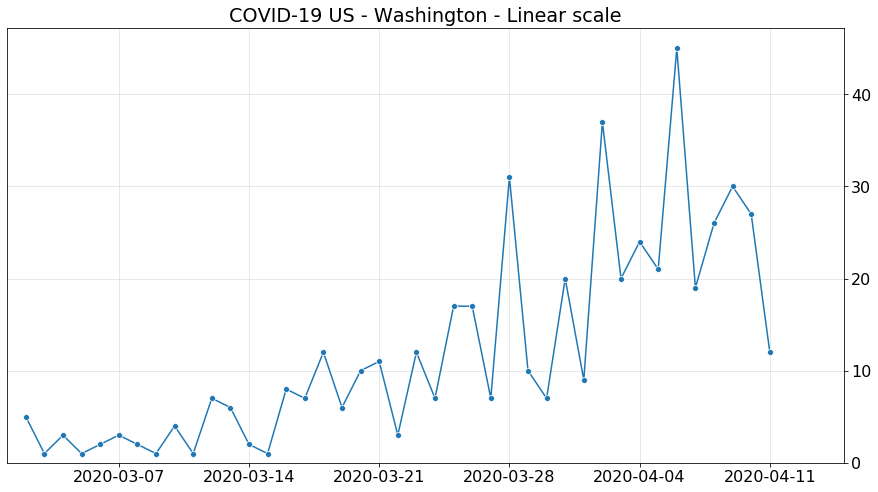

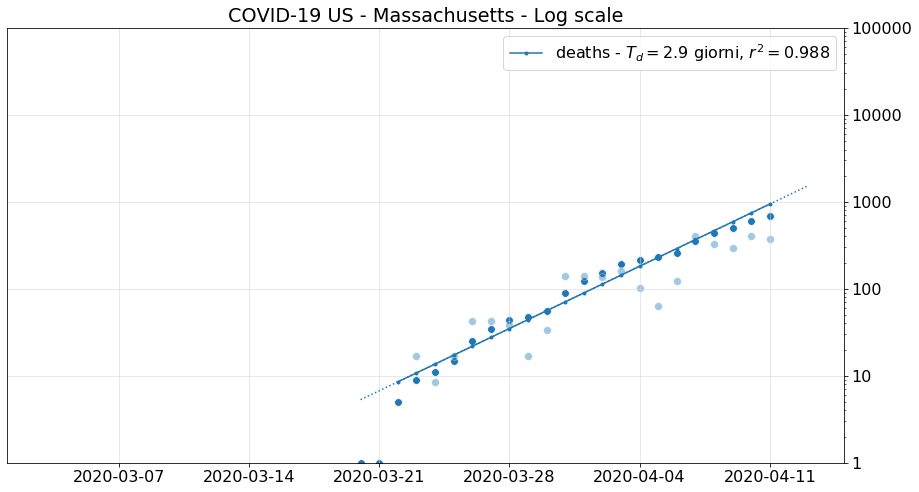

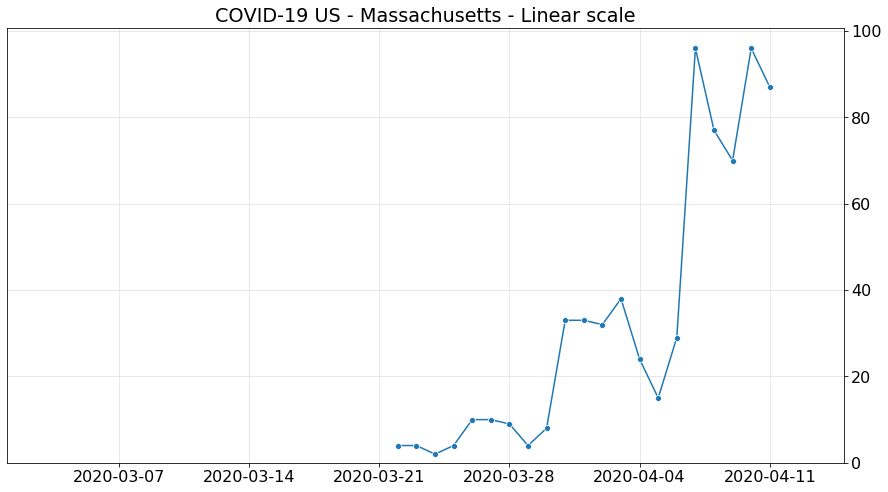

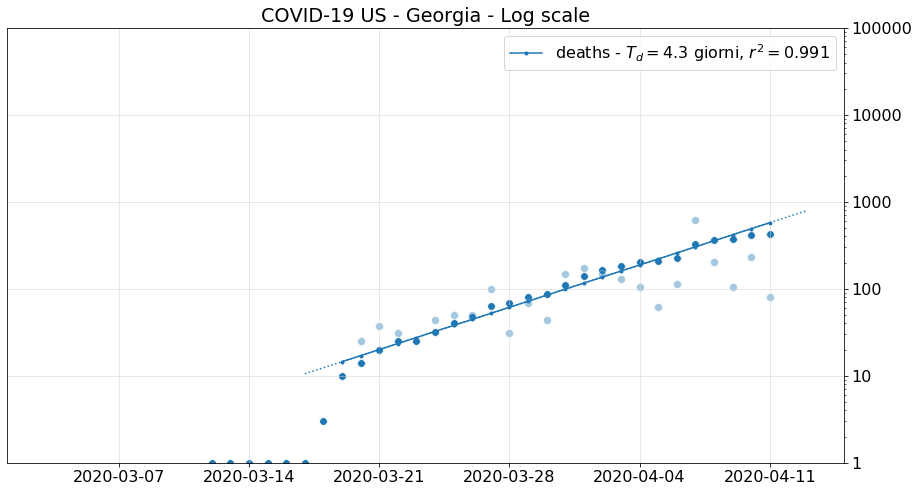

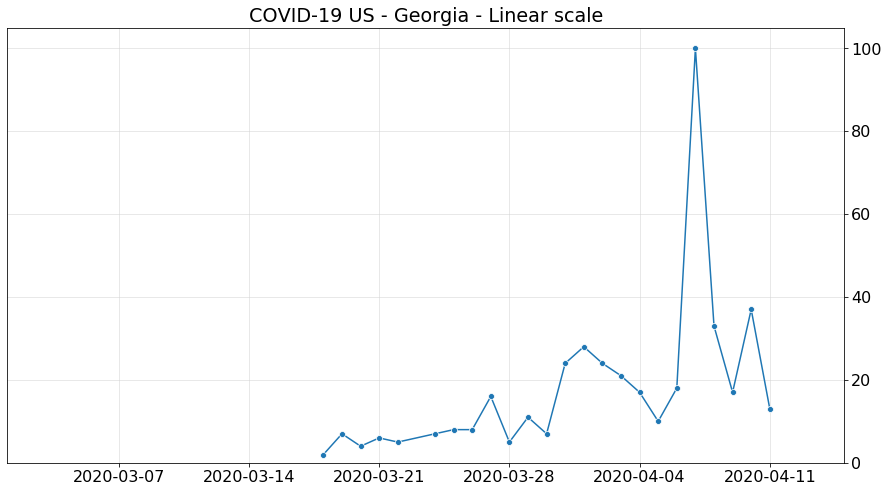

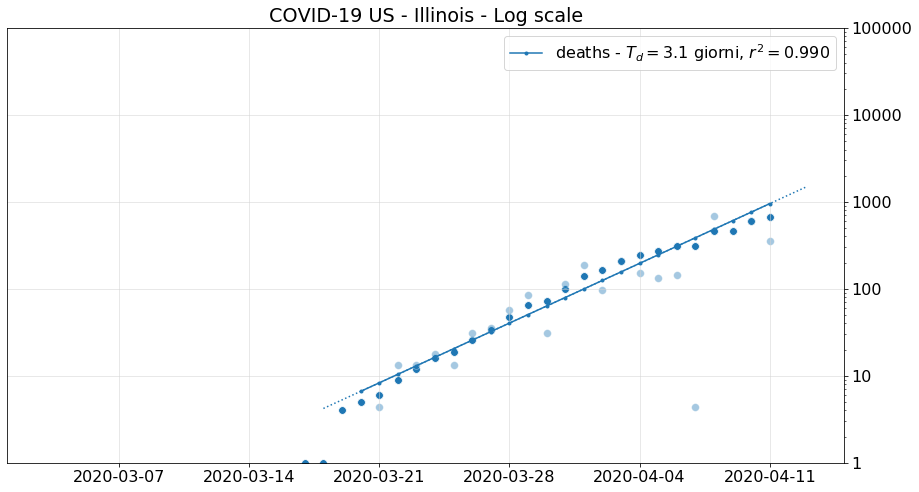

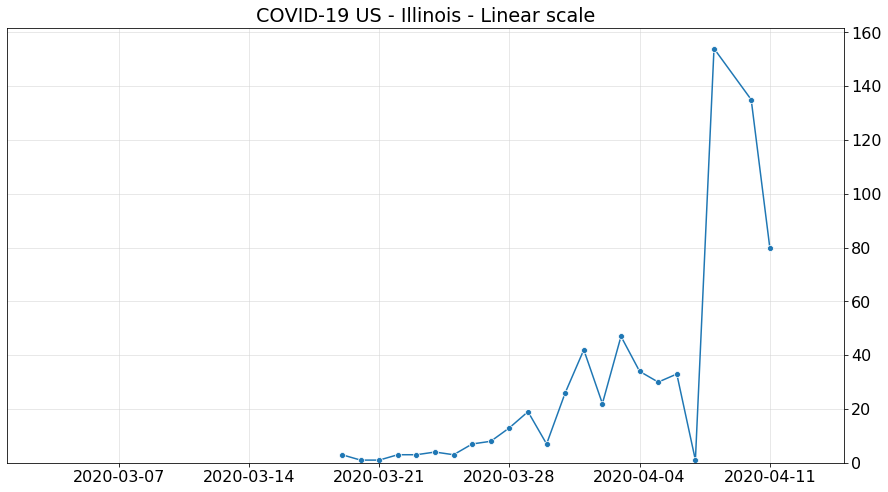

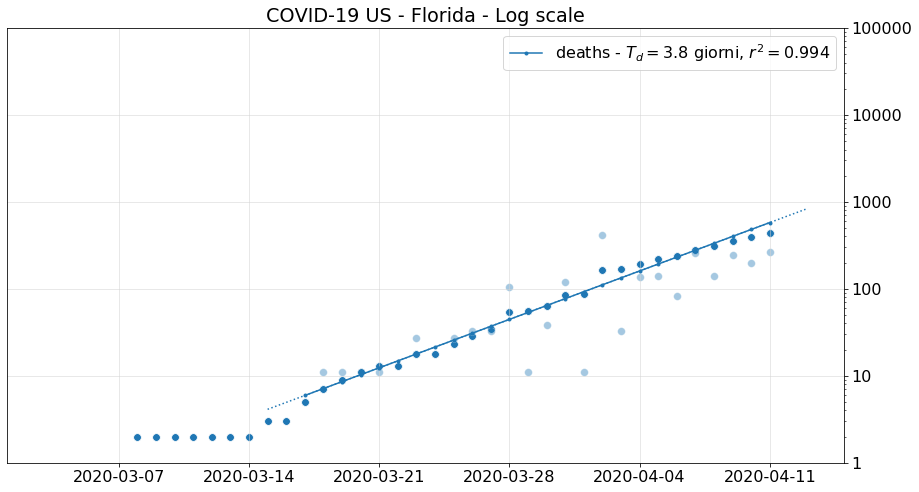

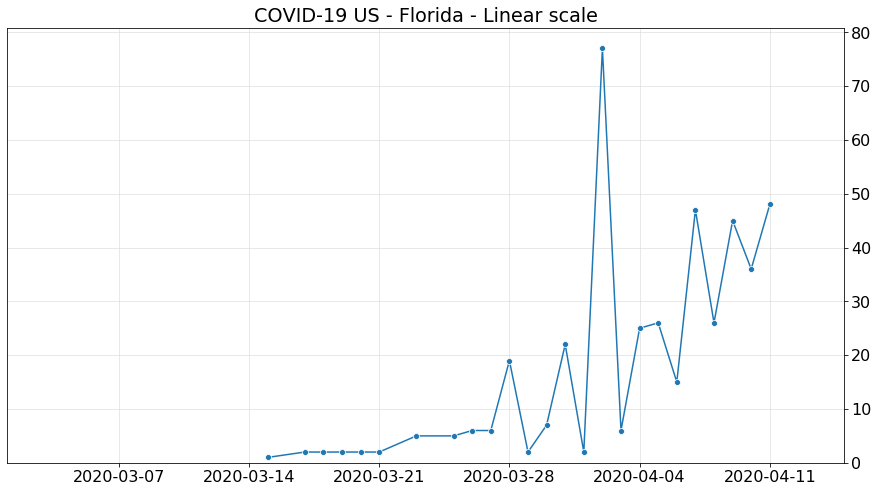

In [35]:

for region, fit_kinds in region_fits.items():
    _, ax0 = plt.subplots(subplot_kw={'xlim': XLIM})
    _, ax1 = plt.subplots(subplot_kw={'xlim': XLIM})

    ax0.set(yscale='log', ylim=(1, 100000)) 
    ax0.set_title(f'COVID-19 {region} - Log scale')
    ax0.yaxis.tick_right()
    ax0.yaxis.grid(color='lightgrey', linewidth=0.5)
    ax0.xaxis.grid(color='lightgrey', linewidth=0.5)

    ax1.set_title(f'COVID-19 {region} - Linear scale')
    ax1.yaxis.tick_right()
    ax1.yaxis.grid(color='lightgrey', linewidth=0.5)
    ax1.xaxis.grid(color='lightgrey', linewidth=0.5)

    for (kind, fits), color in zip(fit_kinds.items(), PALETTE_ONE):
        if kind.startswith('daily_'):
            continue
        for fit in fits:
            covid19.plot.plot_data(ax0, data[region][kind], color=color)
            covid19.plot.plot(ax0, data[region][kind], fit, label=kind, color=color, date_interval=5)
        covid19.plot.plot_data(ax1, data[region]['daily_' + kind], color=color, kind='line', marker='o')
        # covid19.plot.plot(ax1, data[region][kind], fit, label=kind, color=color, date_interval=5, add_diff=False)
    ax1.set(ylim=(0, None)) 


In [38]:
PARAMS = {
    'China - Hubei': -36,
    'Iran': -2,
    'Korea, South': -1,
    'Italy': 0,
    'Spain': 5,
    'France': 10,
    'US': 13,
    'Japan': 13,
    'United Kingdom': 15,
    'Netherlands': 16,
    'Germany': 18,
    'Switzerland': 18,
    'Belgium': 20,
    'Sweden': 23,
    'Austria': 24,
    'Portugal': 24,
}
country_data = {}
for country in PARAMS:
    country_data[country] = world_data[world_data['location'] == country]
    country_data[country]['daily_deaths'] = country_data[country]['deaths'].diff(1)

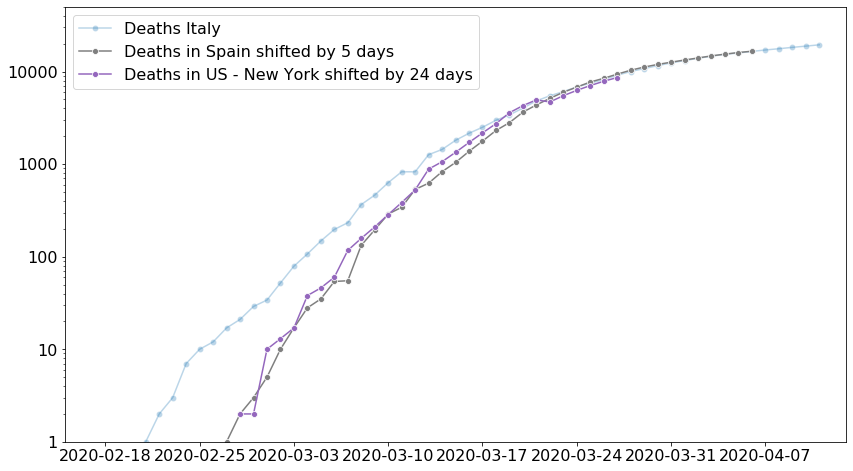

In [59]:
_, ax = plt.subplots(subplot_kw={
    'yscale': 'log',
    'ylim': (1, 50000),
    # 'ylim': (0, country_data['France']['deaths'].max() * 1.1),
    'xlim': (np.datetime64('2020-02-15'), np.datetime64('2020-04-13'))
}, figsize=(14, 8))
covid19.plot.plot_data(ax, country_data['Italy']['deaths'], label=f'Deaths Italy', color=PALETTE_ONE[0], kind='line', marker='o', alpha=0.3)
for (country, delay), color in zip(PARAMS.items(), itertools.cycle(PALETTE_ONE[3:])):
    if country not in ['Spain']: #['France', 'United Kingdom']:
        continue
    covid19.plot.plot_data(ax, country_data[country]['deaths'], label=f'Deaths in {country} shifted by {delay} days', delay=delay, color=color, kind='line', marker='o')
country = 'US - New York'
covid19.plot.plot_data(ax, data[country]['deaths'], label=f'Deaths in {country} shifted by {delay} days', delay=15, color=color, kind='line', marker='o')


##### 